author: Jan Schlüter ([@f0k](https://github.com/f0k)), 2015-10-13

# Introduction #

This example demonstrates how to compute *saliency maps* for a trained neural network -- a visualization of which inputs a neural network used for a particular prediction. This allows an object classifier to be used for object localization, or to better understand misclassifications. Three papers have proposed closely related methods for this:

* [1]: Zeiler et al. (2013): "Visualizing and Understanding Convolutional Networks",
  http://arxiv.org/abs/1311.2901
* [2]: Simonyan et al. (2013): "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps",
  http://arxiv.org/abs/1312.6034
* [3]: Springenberg et al. (2015): "Striving for Simplicity - The All Convolutional Net",
  http://arxiv.org/abs/1412.6806

The common idea is to compute the gradient of the network's prediction with respect to the input, holding the weights fixed. This determines which input elements (e.g., which pixels in case of an input image) need to be changed the least to affect the prediction the most. The sole difference between the three approaches is how they backpropagate through the linear rectifier. Only the second approach actually computes the gradient, the others modify the backpropagation step to do something slightly different. As we will see, this makes a crucial difference for the saliency maps!

# Preparation steps #

We will work on a pre-trained ImageNet model, VGG-16. Let's start by downloading the weights (528 MiB):

In [1]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2017-06-14 16:26:36--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com... 52.216.65.147
Connecting to s3.amazonaws.com|52.216.65.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Server file no newer than local file "vgg16.pkl" -- not retrieving.



We can now load the weights into Python:

In [2]:
try:
    import cPickle as pickle
except ImportError:
    # Python 3
    import pickle
    with open('vgg16.pkl', 'rb') as f:
        model = pickle.load(f, encoding='latin-1')
else:
    # Python 2
    with open('vgg16.pkl', 'rb') as f:
        model = pickle.load(f)

weights = model['param values']  # list of network weight tensors
classes = model['synset words']  # list of class names
mean_pixel = model['mean value']  # mean pixel value (in BGR)
del model

And define and fill the VGG-16 network in Lasagne:

In [3]:
import os
# https://stackoverflow.com/questions/33988334/theano-config-directly-in-script
# disable GPU
os.environ["THEANO_FLAGS"] = "device=cpu,force_device=True"
import lasagne
import theano
assert theano.config.device == 'cpu'
assert theano.config.force_device == True
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
# from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

net = {}
net['input'] = InputLayer((None, 3, 224, 224))
net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
net['pool2'] = PoolLayer(net['conv2_2'], 2)
net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
net['pool3'] = PoolLayer(net['conv3_3'], 2)
net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
net['pool4'] = PoolLayer(net['conv4_3'], 2)
net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
net['pool5'] = PoolLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

lasagne.layers.set_all_param_values(net['prob'], weights)

VGG-16 needs the input image in a specific size (224x224) and format (BGR instead of RGB). We'll define a helper function to download and convert an image ([original source](https://github.com/Lasagne/Recipes/blob/master/examples/ImageNet%20Pretrained%20Network%20%28VGG_S%29.ipynb)):

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
import io
import skimage.transform
#from skimage.io import imread
import torch
# def prepare_image(url):
#     #ext = url.rsplit('.', 1)[1]
#     #img = plt.imread(io.BytesIO(urllib.request.urlopen(url).read()), ext)
#     img = imread(url)
#     # Resize so smallest dim = 256, preserving aspect ratio
#     h, w, _ = img.shape
#     if h < w:
#         img = skimage.transform.resize(img, (256, w*256//h), preserve_range=True)
#     else:
#         img = skimage.transform.resize(img, (h*256//w, 256), preserve_range=True)
#     # Central crop to 224x224
#     h, w, _ = img.shape
#     img = img[h//2-112:h//2+112, w//2-112:w//2+112]
#     # Remember this, it's a single RGB image suitable for plt.imshow()
#     img_original = img.astype('uint8')
#     # Shuffle axes from 01c to c01
#     img = img.transpose(2, 0, 1)
#     # Convert from RGB to BGR
#     img = img[::-1]
#     # Subtract mean pixel value
#     img = img - mean_pixel[:, np.newaxis, np.newaxis]
#     # Return the original and the prepared image (as a batch of a single item)
#     return img_original, lasagne.utils.floatX(img[np.newaxis])

# make sure preprocessing are the same.
from PIL import Image # so, this woorks better than skimage, as torchvision transforms work best with PIL and Tensor.
from torchvision import transforms

def prepare_image(url):
    img_to_use = Image.open(url)
    transform_1 = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
    ])

    # since it's 0-255 range.
    transform_2 = transforms.Compose([
        transforms.ToTensor(),
        # convert RGB to BGR
        # from <https://github.com/mrzhu-cool/pix2pix-pytorch/blob/master/util.py>
        transforms.Lambda(lambda x: torch.index_select(x, 0, torch.LongTensor([2, 1, 0]))),
        transforms.Lambda(lambda x: x*255),
        transforms.Normalize(mean = [103.939, 116.779, 123.68],
                              std = [ 1, 1, 1 ]),
    ])

    img_to_use_cropped = transform_1(img_to_use)
    img_to_use_cropped_tensor = transform_2(img_to_use_cropped)[np.newaxis]  # add first column for batching
    return np.array(img_to_use_cropped), img_to_use_cropped_tensor.numpy().copy()

# Computing a saliency map #

Now that we've got the basics in place, let's define a function to compute a saliency map. As mentioned in the introduction, the main idea is to compute the gradient of the output with respect to the input. More specifically, we are interested in the gradient of the predicted class, that is, the gradient of the unit of maximum activation in the network's output layer (``net['prob']``). The network's output layer has a softmax nonlinearity, though, so the gradient of any output unit will not only tell which inputs are relevant for maximizing the predicted class, but also which ones are relevant for minimizing all the other classes. To get a clearer picture, we will thus take the gradient of the softmax *inputs* (``net['fc8']``).

We will define a helper function for compiling the saliency map function, so we can reuse it for the different ways of propagating through the linear rectifier.

In [5]:
import theano
import theano.tensor as T

def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(net['fc8'], deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

Let us also define a helper function for plotting an input image along with the saliency map. We will display three variants:

1. The magnitude per pixel, taking the maximum magnitude over the three color channels, as in [2], Section 3.1
2. The positive magnitudes (positively correlated with the output), keeping color information
3. The negative magnitudes (negatively correlated with the output), keeping color information

In [6]:
def show_images(img_original, saliency, max_class, title):
    # get out the first map and class from the mini-batch
    print(saliency.dtype, img_original.dtype, max_class,
          saliency.min(), saliency.max(), saliency.mean(), saliency.std())
    saliency = saliency[0]
    max_class = max_class[0]
    # convert saliency from BGR to RGB, and from c01 to 01c
    saliency = saliency[::-1].transpose(1, 2, 0)
    # plot the original image and the three saliency map variants
    plt.figure(figsize=(10, 10), facecolor='w')
    plt.suptitle("Class: " + classes[max_class] + ". Saliency: " + title)
    plt.subplot(2, 2, 1)
    plt.title('input')
    plt.imshow(img_original)
    plt.subplot(2, 2, 2)
    plt.title('abs. saliency')
    plt.imshow(np.abs(saliency).max(axis=-1), cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title('pos. saliency')
    plt.imshow((np.maximum(0, saliency) / saliency.max()))
    plt.subplot(2, 2, 4)
    plt.title('neg. saliency')
    plt.imshow((np.maximum(0, -saliency) / -saliency.min()))
    plt.show()

## Simonyan et al. (2013): Plain Gradient ##

Reference [2] uses the unmodified gradient to compute the saliency map, so this is what we will start with. We will prepare one of the [ILSVRC2012 validation images](http://www.image-net.org/challenges/LSVRC/2012/ori_urls/indexval.html) to feed to the network:

In [7]:
url = './4334173592_145856d89b.jpg'
img_original, img = prepare_image(url)
img.max()

150.061

Then we'll compile the saliency map function, pass the image through it and display the results:

float32 uint8 [55] -0.00239626 0.001981 -2.33064e-07 0.000130566


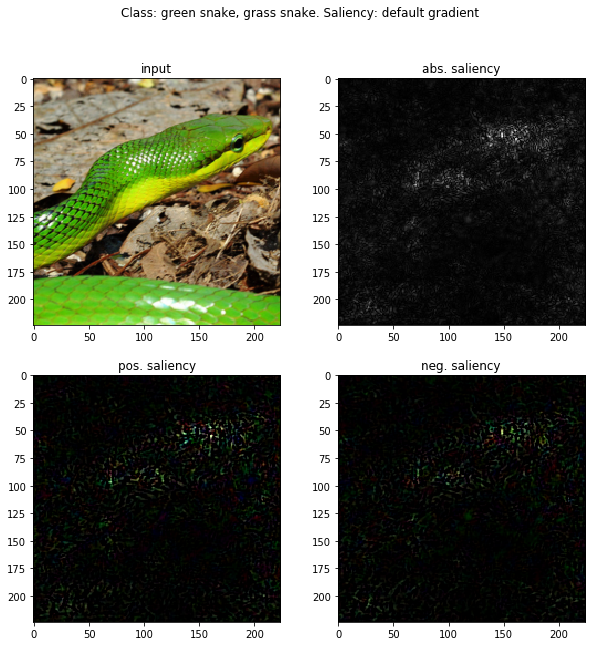

In [8]:
saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "default gradient")

In [9]:
relu = lasagne.nonlinearities.rectify
relu_layers = [layer for layer in lasagne.layers.get_all_layers(net['prob'])
               if getattr(layer, 'nonlinearity', None) is relu]

As in the original paper (Figure 2), the gradient magnitudes roughly show which pixels are relevant for the network predicting "green snake", i.e., where in the picture the detected green snake is visible. But we can do better!

## Springenberg et al. (2015): Guided Backpropagation ##

Reference [3] proposes to change a tiny detail for backpropagating through the linear rectifier $y(x) = max(x, 0) = x \cdot [x > 0]$, the nonlinearity used in all the layers of VGG-16 except for the final output layer (which has a softmax activation).
Here, $[\cdot]$ is the indicator function in [a notation promoted by Knuth](http://www.jstor.org/stable/2325085).

The gradient of the rectifier's output wrt. its input is defined as follows: $\frac{dy}{dx} y(x) = [x > 0]$. So when backpropagating an error signal $\delta_i$ through the rectifier, we retain $\delta_{i-1} = \delta_i \cdot [x > 0]$.
In [3], Section 3.4, Springenberg et al. propose an additional limitation: In addition to propagating the error back to every positive input, only propagate back positive error signals: $\delta_{i-1} = \delta_i \cdot [x > 0] \cdot [\delta_i > 0]$.
They term this "guided backpropagation", because the gradient is guided not only by the input from below, but also by the error signal from above.

To implement this, we need to change the gradient computed by Theano. Luckily, Theano is already organized in entities called Ops that know how to compute some quantity and its partial derivatives. All we need to do is to replace the nonlinearity functions in the network with applications of an Op that computes the nonlinear rectifier in the forward pass, but does guided backpropagation in its backward pass. Implementing an Op can be tedious, but Theano provides a helper function called ``OpFromGraph()`` that turns an expression graph into an Op. We will use this to turn the nonlinearity into an Op, then simply replace its ``grad()`` method -- the one reponsible for giving the partial derivatives -- by a custom implementation.

As we need this for both [3] and [1], we will first define a helper class that allows us to replace a nonlinearity with an Op that has the same output, but a custom gradient:

In [10]:
class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        print('init base')
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
        # OpFromGraph is oblique to Theano optimizations, so we need to move
        # things to GPU ourselves if needed.
        if theano.sandbox.cuda.cuda_enabled:
            maybe_to_gpu = theano.sandbox.cuda.as_cuda_ndarray_variable
        else:
            maybe_to_gpu = lambda x: x
        # We move the input to GPU if needed.
        x = maybe_to_gpu(x)
        # We note the tensor type of the input variable to the nonlinearity
        # (mainly dimensionality and dtype); we need to create a fitting Op.
        tensor_type = x.type
        # If we did not create a suitable Op yet, this is the time to do so.
        if tensor_type not in self.ops:
            # For the graph, we create an input variable of the correct type:
            inp = tensor_type()
            # We pass it through the nonlinearity (and move to GPU if needed).
            outp = maybe_to_gpu(self.nonlinearity(inp))
            # Then we fix the forward expression...
            op = theano.OpFromGraph([inp], [outp])
            # ...and replace the gradient with our own (defined in a subclass).
            op.grad = self.grad
            # Finally, we memoize the new Op
            self.ops[tensor_type] = op
        # And apply the memoized Op to the input we got.
        return self.ops[tensor_type](x)

We can now define a subclass that does guided backpropagation through a nonlinearity:

In [11]:
class GuidedBackprop(ModifiedBackprop):
    def __init__(self, nonlinearity):
        super().__init__(nonlinearity)
        print('init guided')
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)

Finally, we replace all the nonlinearities of the network:

In [12]:
modded_relu = GuidedBackprop(relu)  # important: only instantiate this once!
print(modded_relu.ops)
for layer in relu_layers:
    layer.nonlinearity = modded_relu

init base
init guided
{}


We can now recompile the saliency map function, and compute and display the saliency maps:

-122.68 150.061
float32 uint8 [55] -0.00876065 0.0109609 -2.04625e-05 0.000545016


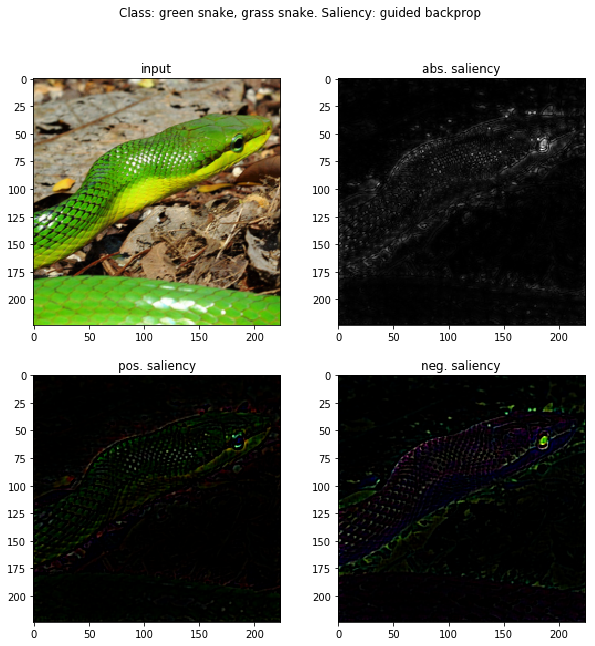

In [13]:
saliency_fn = compile_saliency_function(net)
print(img.min(), img.max())
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "guided backprop")

As in [3], Appendix C, they are considerably more detailed. We can see that the eye is important for the prediction: making its green part black or its black part green would reduce the output activation the most. Note that for guided backpropagation, the negative saliency values only arise from the very first convolution, because negative error signals are never propagated back through the nonlinearities.

## Zeiler et al. (2013): DeconvNet ##

Finally, we will compare results to the DeconvNet proposed in reference [1]. This was actually the first of the pack, but it was easier to start with the unmodified gradient of [2] and continue from there.

The central idea of Zeiler et al. is to visualize layer activations of a ConvNet by running them through a "DeconvNet" -- a network that undoes the convolutions and pooling operations of the ConvNet until it reaches the input space. Deconvolution is defined as convolving an image with the same filters transposed, and unpooling is defined as copying inputs to the spots in the (larger) output that were maximal in the ConvNet (i.e., an unpooling layer uses the switches from its corresponding pooling layer for the reconstruction). Any linear rectifier in the ConvNet is simply copied over to the DeconvNet.

As noted in [2], Section 4, this definition of a DeconvNet exactly corresponds to simply backpropagating through the ConvNet, except for the linear rectifier. So again, this can be implemented by modifying the gradient of the rectifier: Instead of propagating the error back to every positive input, propagate back all positive error signals: $\delta_{i-1} = \delta_i \cdot [\delta_i > 0]$. Note that this is equivalent to applying the linear rectifier to the error signal.

So again, let's define a subclass that does Zeiler's backpropagation through a nonlinearity:

In [14]:
# right.. you see? it's problematic.
class ZeilerBackprop(ModifiedBackprop):
    def __init__(self, nonlinearity):
        super().__init__(nonlinearity)
        print('init zeiler')
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
#         res_ = grd * (grd > 0).astype(inp.dtype)
#         print(type(res_), res_.std(), res_.max())
#         return (res_,)  # explicitly rectify
        #return (self.nonlinearity(grd),)  # use the given nonlinearity
        dtype = inp.dtype
        #return (grd,)
        #return (grd * (grd > 0).astype(dtype),)
        #print(grd.dtype, inp.dtype)
        #return (grd.astype(dtype),)
        #return (grd,)
        #return out_grads
        #return (grd * (grd > 0).astype(grd.dtype),)
        return (self.nonlinearity(grd),)

And again, we'll modify the network, recompile the saliency map function, compute and display the saliency maps:

init base
init zeiler
{}
-122.68 150.061
float32 uint8 [55] -0.926508 0.923794 -0.00483846 0.135563


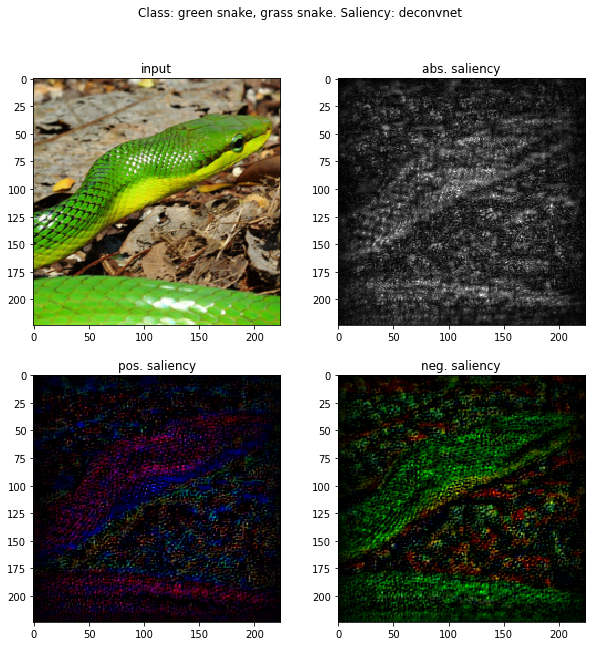

In [15]:
modded_relu_deconv = ZeilerBackprop(relu)
print(modded_relu_deconv.ops)
for layer in relu_layers:
    layer.nonlinearity = modded_relu_deconv
print(img.min(), img.max())
saliency_fn = compile_saliency_function(net)
saliency, max_class = saliency_fn(img)
show_images(img_original, saliency, max_class, "deconvnet")

This is pretty much in line with [3], Appendix C, Figure 5: The DeconvNet reconstructs sharper features than the default gradient, but fails to correctly localize those features in the input image.

## Bonus Image ##

For some images, even the unmodified gradient is largely uninformative, while guided backpropagation works remarkably well:

float32 uint8 [56] -0.0012361 0.00119596 -3.69321e-07 0.000126492


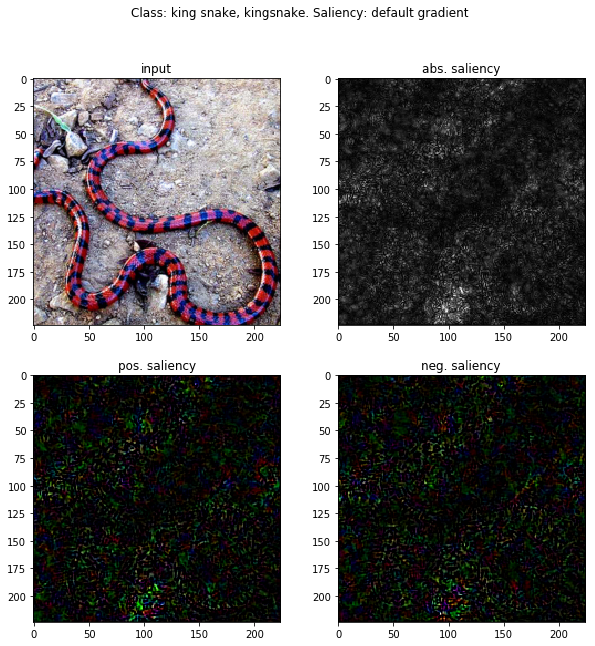

In [16]:
url = './5595774449_b3f85b36ec.jpg'
img_original2, img2 = prepare_image(url)
for layer in relu_layers:
    layer.nonlinearity = relu
saliency_fn = compile_saliency_function(net)
show_images(img_original2, *saliency_fn(img2), title="default gradient")

init base
init guided
{}
float32 uint8 [56] -0.00942203 0.00707957 -2.01891e-05 0.000754746


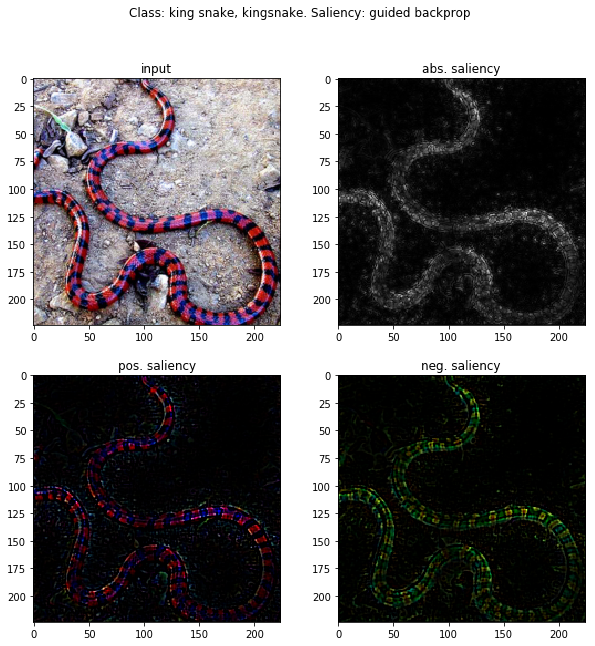

In [17]:
modded_relu = GuidedBackprop(relu)
print(modded_relu.ops)
for layer in relu_layers:
    layer.nonlinearity = modded_relu
saliency_fn = compile_saliency_function(net)
show_images(img_original2, *saliency_fn(img2), title="guided backprop")

# Conclusion #

We have seen how to implement different saliency mapping methods, and compared the results. Guided Backpropagation seems to have a clear advantage over the plain gradient or the DeconvNet.

Note that these methods also work fine for neural networks with leaky rectified units, but, to state the obvious, they are only useful for inspecting a trained network, not for training it.

Have fun debugging your ConvNets!